In [24]:
# ===============================
# Library Imports
# ===============================
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from tqdm import tqdm
import copy
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset, Dataset
from functools import partial
import optuna
from typing import List, Optional, Tuple
from dataclasses import dataclass

In [25]:
# ===============================
# Global Settings for Reproducibility
# ===============================
# Choose device
device = "cpu"
torch.set_num_threads(os.cpu_count())

# Reproducibility
RNG_SEED = 42
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)

In [26]:
# =======================================
# Show the MNIST images from flattened vectors
# =======================================
MNIST_LABELS = [str(i) for i in range(10)]

def plot_mnist_images(
    X: np.ndarray,
    y: np.ndarray,
    y_pred: Optional[np.ndarray] = None,
    num_images: int = 10,
    img_shape: Tuple[int, int] = (28, 28)
):
    """
    Plot MNIST images from flattened vectors

    Parameters
    ----------
    X : np.ndarray
        Flattened MNIST images (N, 784)
    y : np.ndarray
        True labels (N,) or one-hot (N, 10)
    y_pred : np.ndarray, optional
        Predicted labels (N,)
    num_images : int
        Number of images to display
    img_shape : Tuple[int, int]
        MNIST image shape (28, 28)

    Returns
    -------
    None

    Usage Example
    --------------
    plot_mnist_images(X_test, y_test, y_pred=y_pred, num_images=15)
    """
    # Convert labels to integer if needed
    if y.ndim > 1:
        y_true = np.argmax(y, axis=1)
    else:
        y_true = y

    num_images = min(num_images, len(X))

    n_cols = min(5, num_images)
    n_rows = ceil(num_images / n_cols)

    plt.figure(figsize=(3 * n_cols, 3 * n_rows))

    for i in range(num_images):
        plt.subplot(n_rows, n_cols, i + 1)

        img = X[i].reshape(img_shape)
        plt.imshow(img, cmap="gray")
        plt.axis("off")

        title = f"True: {MNIST_LABELS[y_true[i]]}"
        if y_pred is not None:
            title += f"\nPred: {MNIST_LABELS[y_pred[i]]}"
            color = "green" if y_true[i] == y_pred[i] else "red"
            plt.title(title, color=color, fontsize=10)
        else:
            plt.title(title, fontsize=10)

    plt.tight_layout()
    plt.show()

Loading MNIST dataset...
Preprocessing data...


c:\SafApp\Python\Python3.12-64\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\SafApp\Python\Python3.12-64\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Input dimension: 784, Output dimension: 10


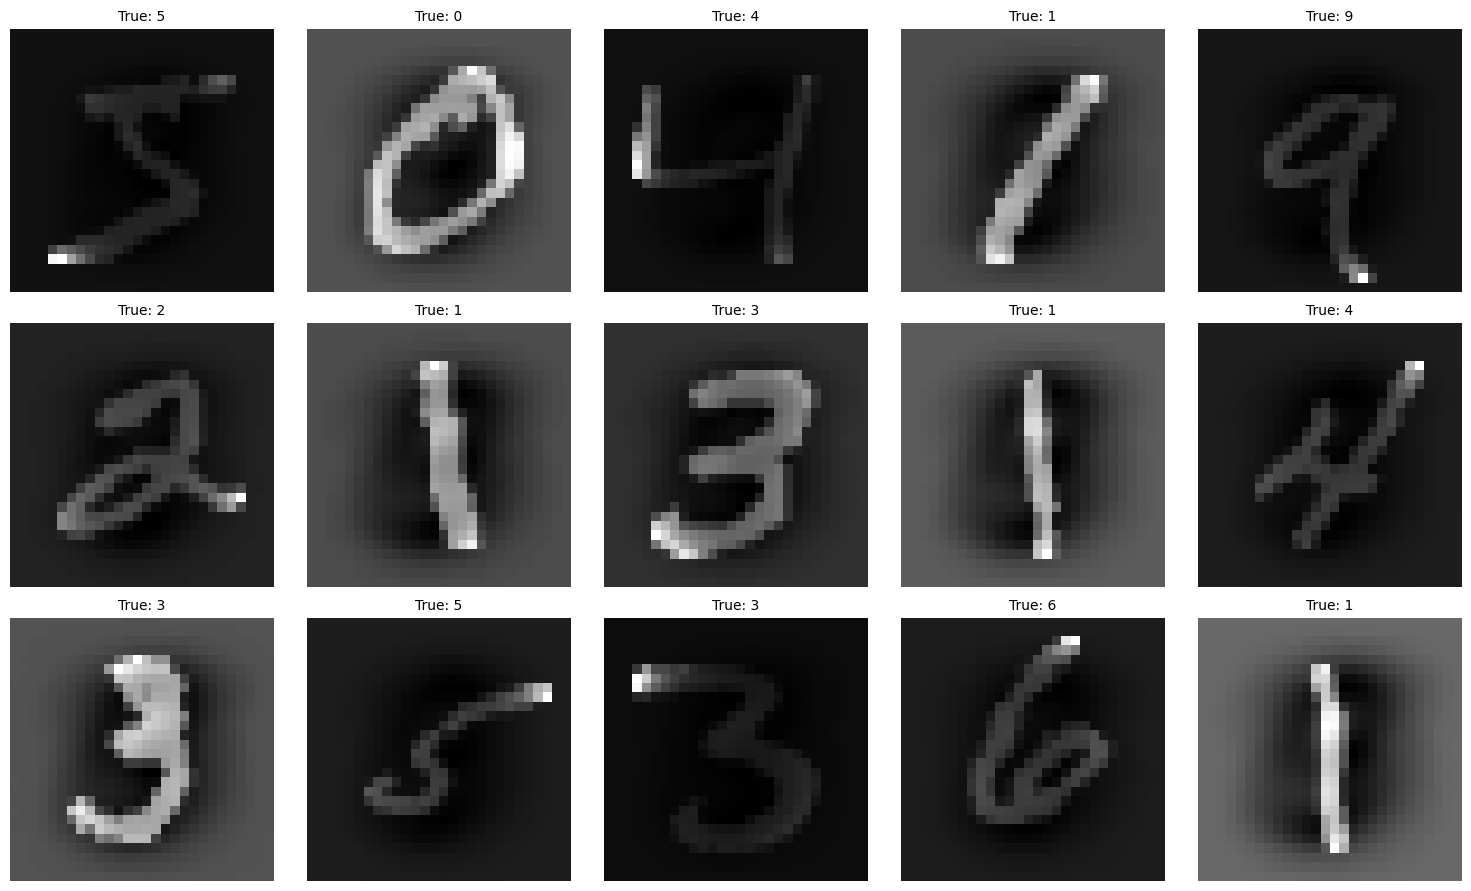

In [ ]:
# =======================================
# Load and Preprocess Data of MNIST
# =======================================
print("Loading MNIST dataset...")
mnist_data = fetch_openml("mnist_784", version=1, as_frame=False)
X = mnist_data["data"]
y = mnist_data["target"]

# Normalize
print("Preprocessing data...")
scaler = StandardScaler()
X = scaler.fit_transform(X)

# One-hot encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(y.reshape(-1, 1))

# Usage:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RNG_SEED, stratify=y)
input_dim = int(X_train.shape[1])
output_dim = int(len(np.unique(y_train)))
print(f"Input dimension: {input_dim}, Output dimension: {output_dim}")

# Plot
plot_mnist_images(X=X_train, y=y_train, num_images=15)

In [28]:
# =======================================
# Tensor Creation
# =======================================
def df_to_tensor_dataset(
    X: np.ndarray,
    y: np.ndarray
) -> TensorDataset:
    """
    Convert numpy arrays to PyTorch TensorDataset

    Parameters
    ----------
    X : np.ndarray
        Feature data
    y : np.ndarray
        Labels

    Returns
    -------
    TensorDataset
        PyTorch TensorDataset containing features and labels

    Usage Example
    --------------
    dataset = df_to_tensor_dataset(X_train, y_train)
    """
    X_tensor = torch.tensor(X, dtype=torch.float)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X_tensor, y_tensor)

def make_dataloaders(
    dataset: Dataset,
    batch_size: int,
    shuffle: bool = False
) -> DataLoader:
    """
    Create DataLoader from Dataset
    
    Parameters
    ----------
    dataset : Dataset
        PyTorch Dataset
    batch_size : int
        Batch size for DataLoader
    shuffle : bool
        Whether to shuffle the data

    Returns
    -------
    DataLoader
        PyTorch DataLoader

    Usage Example
    --------------
    dataloader = make_dataloaders(dataset, batch_size=32, shuffle=True)
    """
    return DataLoader(dataset, 
                      batch_size=batch_size, 
                      shuffle=shuffle, 
                      num_workers=os.cpu_count(), 
                      persistent_workers=True if os.cpu_count() > 1 else False
                    )

In [29]:
# =======================================
# Activation function
# =======================================
_ACTIVATION_MAP = {
    "relu": nn.ReLU,
    "sigmoid": nn.Sigmoid,
    "tanh": nn.Tanh,
    "leaky_relu": lambda: nn.LeakyReLU(negative_slope=0.01),
    "gelu": nn.GELU,
    "elu": nn.ELU,
    "softmax_logit": None  # handled as logits for CrossEntropy
}

In [30]:
# =======================================
# Dataclass for hyperparameters
# =======================================
@dataclass
class TrainConfig:
    hidden_layers: list[int] = None
    activations: Optional[List[float]] = None
    dropout_rates: Optional[List[float]] = None
    loss_function: str = "cross_entropy"
    lr: float = 1e-3
    batch_size: int = 64
    epochs: int = 100
    weight_decay: float = 1e-5
    step_size: int = 20
    gamma: float = 0.5

In [31]:
# =======================================
# DEN Layer for Dynamic Expansion Network
# =======================================
class DENLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.weight = nn.Parameter(torch.empty(out_dim, in_dim))
        nn.init.kaiming_normal_(self.weight, nonlinearity='relu')
        self.bias = nn.Parameter(torch.full((out_dim,), 0.1))

        # frozen mask: False = neuron is trainable
        self.frozen_mask = torch.zeros(out_dim, dtype=torch.bool)

    def forward(self, x):
        # compute linear transformation
        out = F.linear(x, self.weight, self.bias)

        # detach outputs of frozen neurons to prevent gradient flow
        if self.frozen_mask.any():
            out = out.clone()  # ensure we don't modify in-place
            out[:, self.frozen_mask] = out[:, self.frozen_mask].detach()

        return out

    def freeze_existing(self):
        self.frozen_mask[:] = True

    def expand(self, k):
        # add new neurons
        new_w = nn.Parameter(torch.empty(k, self.in_dim))
        nn.init.kaiming_normal_(new_w, nonlinearity='relu')
        new_b = nn.Parameter(torch.full((k,), 0.1))

        self.weight = nn.Parameter(torch.cat([self.weight, new_w], dim=0))
        self.bias = nn.Parameter(torch.cat([self.bias, new_b], dim=0))
        self.frozen_mask = torch.cat([self.frozen_mask, torch.zeros(k, dtype=torch.bool)])
        self.out_dim += k

In [32]:
# =======================================
# Dynamic Expansion Network (DEN)
# =======================================
class DEN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, use_leakyrelu=False):
        super().__init__()
        self.hidden_dims = hidden_dims

        self.layers = nn.ModuleList()
        prev = input_dim

        for h in hidden_dims:
            self.layers.append(DENLayer(prev, h))
            prev = h

        self.classifier = nn.Linear(prev, output_dim)
        nn.init.kaiming_normal_(self.classifier.weight, nonlinearity='linear')
        nn.init.constant_(self.classifier.bias, 0.0)

        self.use_leakyrelu = use_leakyrelu

    def forward(self, x):
        for layer in self.layers:
            if self.use_leakyrelu:
                x = F.leaky_relu(layer(x), negative_slope=0.01)
            else:
                x = F.relu(layer(x))
        return self.classifier(x)

In [33]:
# =======================================
# DEN expansion logic: expand only if new task cannot be learned well
# =======================================
def needs_expansion(model, grad_threshold=1e-3):
    conflict = 0.0
    count = 0

    for layer in model.layers:
        if layer.frozen_mask.any() and layer.weight.grad is not None:
            frozen_grads = layer.weight.grad[layer.frozen_mask]
            conflict += frozen_grads.norm().item()
            count += frozen_grads.numel()

    return (conflict / (count + 1e-8)) > grad_threshold


def expand_den(model, k):
    for i, layer in enumerate(model.layers):
        layer.expand(k)

        # expand next layer input
        if i + 1 < len(model.layers):
            next_layer = model.layers[i + 1]

            old_w = next_layer.weight.detach()
            # use proper Kaiming init for new columns
            new_cols = nn.init.kaiming_normal_(torch.empty(next_layer.out_dim, k), nonlinearity='relu')

            next_layer.weight = nn.Parameter(torch.cat([old_w, new_cols], dim=1))
            next_layer.in_dim += k

    # expand classifier input
    old_w = model.classifier.weight.detach()
    old_b = model.classifier.bias.detach()

    out_dim, old_in = old_w.shape
    new_w = nn.init.kaiming_normal_(torch.empty(out_dim, k), nonlinearity='linear')

    model.classifier = nn.Linear(old_in + k, out_dim)
    model.classifier.weight.data = torch.cat([old_w, new_w], dim=1)
    model.classifier.bias.data.copy_(old_b)

In [34]:
# =======================================
# Loss function for task specific classes
# =======================================
def class_il_loss(logits, targets, task_classes):
    """
    logits: (N, 10)
    targets: (N,) with labels in [0..9]
    task_classes: e.g. [2,3]
    """
    # extract only task logits
    task_logits = logits[:, task_classes]

    # remap labels: {2,3} → {0,1}
    label_map = {c: i for i, c in enumerate(task_classes)}
    task_targets = torch.tensor(
        [label_map[int(y)] for y in targets],
        device=targets.device
    )

    return F.cross_entropy(task_logits, task_targets)


In [35]:
# =======================================
# Freeze LOW-importance neurons
# =======================================
def freeze_neurons(model, percentile=20):
    """
    Freeze bottom X% of neurons in each layer based on gradient importance.
    Only call after a task has converged.
    """
    for layer in model.layers:
        if layer.weight.grad is None:
            continue

        # gradient norm per neuron
        grad_norm = layer.weight.grad.norm(dim=1)
        importance = grad_norm / (grad_norm.max() + 1e-8)

        # freeze bottom X% neurons
        cutoff = torch.quantile(importance, percentile / 100)
        layer.frozen_mask |= importance < cutoff

In [36]:
# =======================================
# Training Loop
# =======================================
def train_model_on_task(
    model, 
    train_dataset,
    task_classes,
    batch_size: int = 64,
    learning_rate = 0.001,
    weight_decay = 0.00001,
    lambda_sparse: float = 1e-5,
    epochs: int = 10,
    print_every: Optional[int] = 1
):  
    # Data preparation
    train_loader = make_dataloaders(train_dataset, batch_size, shuffle=True)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    final_loss = 0.0

    for epoch in range(epochs):
        epoch_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            
            logits = model(X_batch)
            loss = class_il_loss(logits, y_batch, task_classes)
            # group sparsity
            loss += lambda_sparse * sum(layer.weight[~layer.frozen_mask].norm(p=2, dim=1).sum() for layer in model.layers)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item() * X_batch.size(0)

        final_loss = epoch_loss / len(train_loader.dataset)
        # Print progress
        if (epoch+1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {final_loss:.4f}") 

    return final_loss

In [37]:
# =======================================
# Prediction
# =======================================
def predict_loader_class_il(model, loader, seen_classes, device=None):
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    all_preds, all_targets = [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            # take only seen classes
            task_logits = logits[:, seen_classes]

            # prediction index in task_logits
            preds_task = task_logits.argmax(dim=1)

            # remap back to original labels
            preds = torch.tensor([seen_classes[i] for i in preds_task], device=device)

            all_preds.append(preds.cpu())
            all_targets.append(y_batch.cpu())

    return torch.cat(all_preds).numpy(), torch.cat(all_targets).numpy()

# =======================================
# Evaluation during training
# =======================================
def accuracy_score(y_true, y_pred):
    return (y_true == y_pred).mean()


def evaluate(model, dataset, seen_classes, device, batch_size=64):
    loader = make_dataloaders(dataset, batch_size=batch_size, shuffle=False)
    y_pred, y_true = predict_loader_class_il(model, loader, seen_classes, device)
    return accuracy_score(y_true, y_pred)

In [38]:
def filter_dataset_by_classes(dataset, allowed_classes):
    X, y = dataset.tensors
    mask = torch.isin(y, torch.tensor(allowed_classes))
    return torch.utils.data.TensorDataset(X[mask], y[mask])

In [39]:
# =======================================
# Create TASK-IL tasks
# =======================================
num_tasks = 5
tasks = []
digits_per_task = 10 // num_tasks
for t in range(num_tasks):
    digit_indices = np.where((y_train >= t * digits_per_task) & (y_train < (t + 1) * digits_per_task))[0]
    X_task = X_train[digit_indices]
    y_task = y_train[digit_indices]
    task_dataset = df_to_tensor_dataset(X_task, y_task)
    tasks.append(task_dataset)
print(f"Created {len(tasks)} tasks.")
for i, task in enumerate(tasks):
    print(f" Task {i} of len {len(task)} with labels {task.tensors[1][:10]} ...")

full_test_dataset = df_to_tensor_dataset(X_test, y_test)
print(f"Full test dataset {i} of len {len(full_test_dataset)} with labels {full_test_dataset.tensors[1][:10]} ...")

Created 5 tasks.
 Task 0 of len 12665 with labels tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 0]) ...
 Task 1 of len 12089 with labels tensor([2, 3, 3, 3, 2, 2, 3, 2, 3, 3]) ...
 Task 2 of len 11263 with labels tensor([5, 4, 4, 5, 4, 4, 5, 5, 4, 4]) ...
 Task 3 of len 12183 with labels tensor([6, 7, 6, 7, 6, 6, 7, 6, 7, 7]) ...
 Task 4 of len 11800 with labels tensor([9, 8, 9, 9, 8, 9, 8, 9, 9, 8]) ...
Full test dataset 4 of len 10000 with labels tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]) ...


In [40]:
# =======================================
# Initialize model and optimizer
# =======================================
den_model_test = DEN(input_dim=input_dim, hidden_dims=[128], output_dim=output_dim)
den_model_test.to(device)
batch_size = 16
learning_rate = 0.001
weight_decay = 0.00001
epochs = 10
print(den_model_test)

DEN(
  (layers): ModuleList(
    (0): DENLayer()
  )
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)


In [41]:
task_classes = [0, 1]
train_loader = make_dataloaders(tasks[0], batch_size)
X_batch, y_batch = next(iter(train_loader))
X_batch, y_batch = X_batch.to(device), y_batch.to(device)
outputs = den_model_test(X_batch)
print(outputs.abs().max())  # should be <~100 ideally

tensor(3.1638, grad_fn=<MaxBackward1>)


In [42]:
task_classes = [0, 1]
train_loader = make_dataloaders(tasks[0], batch_size)
X_batch, y_batch = next(iter(train_loader))
X_batch, y_batch = X_batch.to(device), y_batch.to(device)

outputs = den_model_test(X_batch)
loss = class_il_loss(outputs, y_batch, task_classes)
loss.backward()

for name, param in den_model_test.named_parameters():
    print(name, param.grad.abs().mean().item())


layers.0.weight 0.007193764206022024
layers.0.bias 0.011997087858617306
classifier.weight 0.022775493562221527
classifier.bias 0.02305394969880581


In [43]:
X_batch, y_batch = next(iter(train_loader))
logits = den_model_test(X_batch)
print(logits[:, task_classes].mean(), logits[:, task_classes].std())

tensor(0.1307, grad_fn=<MeanBackward0>) tensor(0.5056, grad_fn=<StdBackward0>)


In [44]:
X_batch, y_batch = next(iter(train_loader))
X_batch, y_batch = X_batch.to(device), y_batch.to(device)
outputs = den_model_test(X_batch)
task_logits = outputs[:, task_classes]
print(task_logits)  # should be ~1–2 logits with meaningful values

tensor([[-0.0362,  0.8124],
        [ 0.7187, -0.4602],
        [-0.6668, -0.0286],
        [-0.2411,  0.1830],
        [ 0.6019, -0.1183],
        [ 0.6445,  0.8539],
        [ 0.7224, -0.4237],
        [ 0.1862,  0.8998],
        [ 0.2940, -0.2368],
        [ 0.1832, -0.9512],
        [-0.3119, -0.0649],
        [ 0.1222,  0.2872],
        [-0.0046, -0.5827],
        [ 1.2703,  0.0455],
        [ 0.4161, -0.1879],
        [ 0.1010,  0.1543]], grad_fn=<IndexBackward0>)


In [45]:
# =======================================
# Train only first task (e.g. digits 0–1) for sanity check to see if it's working fine
# =======================================
task_classes = [0, 1]
seen_classes = [0, 1]

task0_dataset = tasks[0]
loss = train_model_on_task(den_model_test, task0_dataset, task_classes, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate, weight_decay=weight_decay)

test_dataset = df_to_tensor_dataset(X_test, y_test)
seen_test_dataset = filter_dataset_by_classes(
    df_to_tensor_dataset(X_test, y_test),
    seen_classes
)
acc = evaluate(den_model_test, seen_test_dataset, seen_classes, device)
print(f"Accuracy on seen classes: {acc:.4f}")

Epoch [1/10] | Train Loss: 0.0089
Epoch [2/10] | Train Loss: 0.0033
Epoch [3/10] | Train Loss: 0.0023
Epoch [4/10] | Train Loss: 0.0017
Epoch [5/10] | Train Loss: 0.0023
Epoch [6/10] | Train Loss: 0.0040
Epoch [7/10] | Train Loss: 0.0014
Epoch [8/10] | Train Loss: 0.0013
Epoch [9/10] | Train Loss: 0.0011
Epoch [10/10] | Train Loss: 0.0010
Accuracy on seen classes: 0.9995


In [46]:
# =======================================
# Initialize model and optimizer
# =======================================
den_model = DEN(input_dim=input_dim, hidden_dims=[128, 256, 128], output_dim=output_dim)
den_model.to(device)
batch_size = 16
learning_rate = 0.001
weight_decay = 0.00001
epochs = 10
print(den_model)

DEN(
  (layers): ModuleList(
    (0-2): 3 x DENLayer()
  )
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)


In [47]:
# =======================================
# Example Continual Learning Usage with EWC + Replay and Metrics Tracking
# =======================================
expansion_threshold = 0.25
k = 32
task_class_map = [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
seen_classes = []

for t, task_dataset in enumerate(tasks):
    task_classes = task_class_map[t]
    seen_classes += task_classes
    print(f"\n=== Task {t} | Classes {task_classes} ===")


    # Train on current task 
    loss = train_model_on_task(
        model=den_model,
        train_dataset=task_dataset, 
        task_classes=task_classes,
        batch_size=batch_size, 
        epochs=epochs, 
        learning_rate=learning_rate, 
        weight_decay=weight_decay
    )

    if needs_expansion(den_model):
        print("Expanding")
        expand_den(den_model, k)

        # retrain after expansion
        loss = train_model_on_task(
            model=den_model,
            train_dataset=task_dataset, 
            task_classes=task_classes,
            batch_size=batch_size, 
            epochs=epochs, 
            learning_rate=learning_rate, 
            weight_decay=weight_decay
        )

    freeze_neurons(den_model)

    acc = evaluate(den_model, task_dataset, seen_classes, device, batch_size)
    print(f"Accuracy after task {t}: {acc:.4f}")


=== Task 0 | Classes [0, 1] ===
Epoch [1/10] | Train Loss: 0.0215
Epoch [2/10] | Train Loss: 0.0096
Epoch [3/10] | Train Loss: 0.0092
Epoch [4/10] | Train Loss: 0.0076
Epoch [5/10] | Train Loss: 0.0062
Epoch [6/10] | Train Loss: 0.0059
Epoch [7/10] | Train Loss: 0.0056
Epoch [8/10] | Train Loss: 0.0053
Epoch [9/10] | Train Loss: 0.0073
Epoch [10/10] | Train Loss: 0.0032
Accuracy after task 0: 1.0000

=== Task 1 | Classes [2, 3] ===
Epoch [1/10] | Train Loss: 0.0992
Epoch [2/10] | Train Loss: 0.0362
Epoch [3/10] | Train Loss: 0.0260
Epoch [4/10] | Train Loss: 0.0178
Epoch [5/10] | Train Loss: 0.0147
Epoch [6/10] | Train Loss: 0.0082
Epoch [7/10] | Train Loss: 0.0125
Epoch [8/10] | Train Loss: 0.0116
Epoch [9/10] | Train Loss: 0.0102
Epoch [10/10] | Train Loss: 0.0095
Accuracy after task 1: 0.9662

=== Task 2 | Classes [4, 5] ===
Epoch [1/10] | Train Loss: 0.0724
Epoch [2/10] | Train Loss: 0.0185
Epoch [3/10] | Train Loss: 0.0074
Epoch [4/10] | Train Loss: 0.0070
Epoch [5/10] | Train Lo

In [ ]:
# =======================================
# final calibration phase
# =======================================
# freeze feature extractor
for layer in den_model.layers:
    layer.freeze_existing()

# retrain ONLY classifier on all seen data
den_model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(den_model.classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)
full_train_loader = make_dataloaders(df_to_tensor_dataset(X_train, y_train), batch_size, shuffle=True)

for epoch in range(epochs):
    epoch_loss = 0.0
    for X_batch, y_batch in full_train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = den_model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)

    print(f"[Calibration] Epoch {epoch+1}/{epochs} | Loss: {epoch_loss / len(full_train_loader.dataset):.4f}")

[Calibration] Epoch 1/10 | Loss: 0.9769
[Calibration] Epoch 2/10 | Loss: 0.7800
[Calibration] Epoch 3/10 | Loss: 0.7398
[Calibration] Epoch 4/10 | Loss: 0.7135
[Calibration] Epoch 5/10 | Loss: 0.7000
[Calibration] Epoch 6/10 | Loss: 0.6865
[Calibration] Epoch 7/10 | Loss: 0.6784
[Calibration] Epoch 8/10 | Loss: 0.6706
[Calibration] Epoch 9/10 | Loss: 0.6633
[Calibration] Epoch 10/10 | Loss: 0.6582


In [53]:
# =======================================
# Final evaluation
# =======================================
test_dataset = df_to_tensor_dataset(X_test, y_test)
test_loader = make_dataloaders(test_dataset, batch_size=64, shuffle=False)

# seen_classes = all classes learned so far
seen_classes = list(range(10))

y_pred, y_true = predict_loader_class_il(den_model, test_loader, seen_classes, device)

acc = accuracy_score(y_true, y_pred)
print(f"\nFinal Test Accuracy after all tasks: {acc:.4f}")


Final Test Accuracy after all tasks: 0.7554
